In [1]:
%matplotlib inline
import sys
sys.path.append('../src')

import torch
from torch.nn import functional as F
import numpy as np
from abc import ABC, abstractmethod
import stlcg 
import stlviz 

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [2]:
# figure settings
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [3]:
RNG_seed = 1

In [4]:
# function to generate multimodal trajectory data
def generate_data(N=50, plot_fig=False):
    λ = 0.7
    ω = 0.5
    A = 0.7
    B = 1.1
    σ1 = 0.05
    σ2 = 0.02
    alpha = 0.2
    tmax = 10
    dt = 0.25
    t = np.arange(0, tmax, dt)
    y1 = A - np.exp(-4*λ*t) * (A * np.cos(ω * t) + B * np.sin(ω * t))
    y2 = np.exp(-λ*t) * 5 * B * np.sin(0.5 * ω * t)
    y3 = 0.5*(A - np.exp(-4*λ*t) * (A * np.cos(ω * t) + B * np.sin(ω * t)))

    noisy_y1 = (np.expand_dims(y1, 0) * (1 + σ1 * np.random.randn(N, 1))) + σ2 * np.random.randn(N,len(t))
    noisy_y2 = (np.expand_dims(y2, 0) * (1 + σ1 * np.random.randn(N, 1))) + σ2 * np.random.randn(N,len(t))
    noisy_y3 = (np.expand_dims(y3, 0) * (1 + σ1 * np.random.randn(N, 1))) + σ2 * np.random.randn(N,len(t))

    if plot_fig:
        fontsize = 24
        plt.figure(figsize=(16,8))
        plt.plot(t, y1, linewidth=4)
        plt.plot(t, y2, linewidth=4)
        plt.plot(t, y3, linewidth=4)

        plt.plot(t, noisy_y1.T, alpha=alpha, c="lightskyblue")
        plt.plot(t, noisy_y2.T, alpha=alpha, c="orange")
        plt.plot(t, noisy_y3.T, alpha=alpha, c="green")

        plt.xlabel("Time", fontsize=fontsize)
        plt.ylabel("x", fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        plt.savefig("figs/latent_space_data.pdf")
    return t, np.concatenate([y1, y2, y3]), np.concatenate([noisy_y1, noisy_y2, noisy_y3])

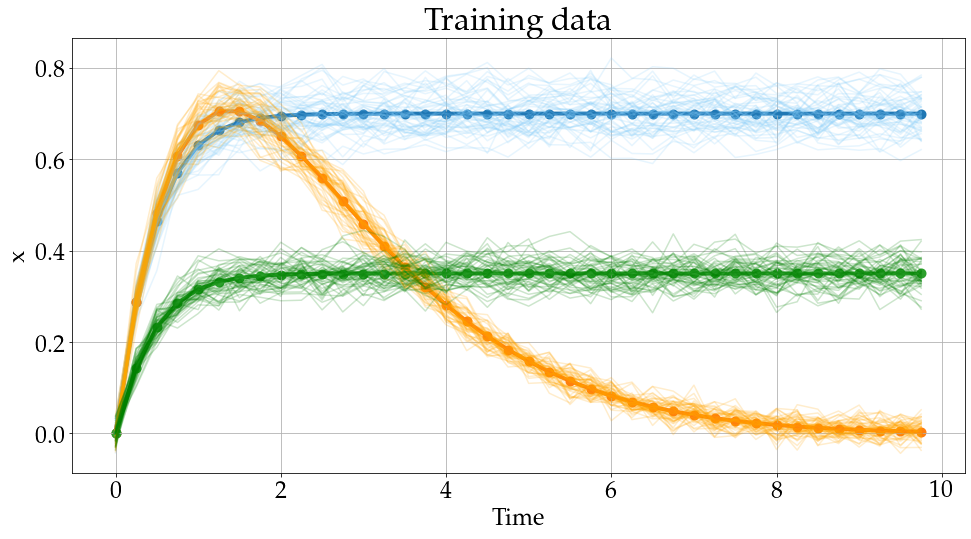

In [5]:
# visualizing trajectories (not the actual training data used. This code block if purely for visualization purposes.)
N = 50
fontsize = 24
alpha = 0.2


np.random.seed(RNG_seed)
t, data, noisy_data = generate_data(N)
y1, y2, y3 = np.split(data, 3)
noisy_y1, noisy_y2, noisy_y3 = np.split(noisy_data, 3, 0)


plt.figure(figsize=(16,8))
plt.plot(t, y1, linewidth=4)
plt.plot(t, y2, linewidth=4)
plt.plot(t, y3, linewidth=4)

plt.scatter(t, y1, linewidth=4)
plt.scatter(t, y2, linewidth=4)
plt.scatter(t, y3, linewidth=4)

plt.plot(t, noisy_y1.T, alpha=alpha, c="lightskyblue")
plt.plot(t, noisy_y2.T, alpha=alpha, c="orange")
plt.plot(t, noisy_y3.T, alpha=alpha, c="green")

plt.xlabel("Time", fontsize=fontsize)
plt.ylabel("x", fontsize=fontsize)
plt.title("Training data", fontsize=fontsize+8)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid()


In [6]:
# Defining the VAE neural network model
# Uses LSTM for the encoder and decoder
# hidden_size is the dimensions for the LSTM hidden state
# latent_size is the size of the latent space
# A discrete latent space is used

class VAE(torch.nn.Module):
    def __init__(self, hidden_size=32, latent_size=16):
        super(VAE, self).__init__()
        self.latent_size = latent_size
        # LSTM encoder
        self.rnn_encoder = torch.nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        # LSTM decoder
        self.rnn_decoder = torch.nn.LSTM(input_size=1, hidden_size=hidden_size, batch_first=True)
        # projection from encoder state into latent space
        self.fc1 = torch.nn.Linear(hidden_size, latent_size)
        # projection from decoder state into output state
        self.fc2 = torch.nn.Linear(hidden_size, 1)
        # projection from latent state into initial LSTM decoder state
        self.fc_to_rnn1 = torch.nn.Linear(latent_size, hidden_size)
        self.fc_to_rnn2 = torch.nn.Linear(latent_size, hidden_size)
   
    def encode(self, x):
        '''
        The encoder takes in the signal and passes it through an LSTM network.
        The last output of the LSTM is projected the probabilities used to construct the discrete latent space.
        '''
        o, h = self.rnn_encoder(x)
        return F.softmax(self.fc1(o[:,-1,:]), -1)   # last output state [bs, latent_size]

    def reparameterize(self, p, k, temp):
        '''
        Reparameterization for a discrete latent space
        During training time, we sample from a RelaxedOneHotCategorical distribution to backpropagate through the network.
        The relaxation is controlled by a temperature parameter that anneals over the training iterations.
        During test/eval time, we sample from the OneHotCategorial distribution.
        '''
        if self.training:
            # At training time we sample from a relaxed Gumbel-Softmax Distribution. 
            # The samples are continuous but when we increase the temperature the samples gets closer to a Categorical distribution.
            m = torch.distributions.RelaxedOneHotCategorical(temp, p)
            return m.rsample(torch.Size([k])).view([-1, self.latent_size])  # [k*bs, latent_size]
        else:
            # At testing time we sample from a Categorical Distribution.
            m = torch.distributions.OneHotCategorical(p)
            return m.sample(torch.Size([k])).view([-1, self.latent_size])  # [k*bs, latent_size]

    def decode(self, z, x, probs=0.1, t_max=None):
        '''
        The latent vector z is used to initialize the initial LSTM decoder state.
        A linear projection is used to project the LSTM decoder output state into the signal state.
        probs is the probability that the previous output will be used as the next LSTM input. 
        Otherwise the true input value from the dataset will be used instead.
        '''
        if t_max is None:
            t_max = x.shape[1]
        h = (self.fc_to_rnn1(z).unsqueeze(0), self.fc_to_rnn1(z).unsqueeze(0))
        xs = x.split(1, 1)
        os = []
        ys = [xs[0]]
        ps = torch.rand(t_max).to(device)
        if not self.training:
            probs = 1
        xi = xs[0]
        for ti in range(t_max-1):
            oi, h = self.rnn_decoder(xi, h)
            os.append(oi)
            yi = self.fc2(oi)
            xi = yi if ps[ti] <= probs else xs[ti+1]
            ys.append(yi)
        return torch.cat(ys, dim=1)
        
    def forward(self, x, temp, probs, k=1):
        p = self.encode(x)
        z = self.reparameterize(p, k, temp)
        return self.decode(z, x.repeat([k,1,1]), probs), p, z



In [7]:
# training parameters

batch_size = 16            # training batch size
test_batch_size = 4        # test batch size
test_k = 1                 # number of times to sample from the latent space (for plotting purposes)
epochs = 50                # number of training iterations
seed = 1                   # random seed number
log_interval = 10          # frequency to print training progress and plotting 

use_cuda = torch.cuda.is_available()    # use GPU if available
torch.manual_seed(seed)    # set seed number  

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


In [8]:
# network parameters
hidden_size = 16           # size of LSTM hidden state 
latent_size = 3            # size of latent space. Chosen to be 3 based on the three trajectories in the dataset

# instantiating the models. Using the same seed to make sure they are intialized identically
torch.manual_seed(seed)    # setting seed 
vae = VAE(hidden_size=hidden_size, latent_size=latent_size).to(device)
torch.manual_seed(seed)    # setting seed
stlvae = VAE(hidden_size=hidden_size, latent_size=latent_size).to(device)
# optimizers
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
stlvae_optimizer = torch.optim.Adam(stlvae.parameters(), lr=1e-3)


In [9]:
# Dataset structure
class VAEDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = dataset  # [bs, time, state_dim]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx,:,:]

# VAE loss function
def vae_loss_function(recon_x, x, p, k):
    '''
    recon_loss is the reconstruction loss. We use the sum of the error**2 over each trajectory, then mean over the batch
    kl_loss the the Kullback–Leibler divergence term for the categorical distribution. It is compared against a uniform distribution
    '''
    recon_loss = ((recon_x - x.repeat([k,1,1]))**2).squeeze().sum(1).mean(0)
    kl_loss = (p * (torch.log(p) - np.log(0.5))).sum(-1).mean()
    elbo = recon_loss - kl_loss
    return elbo

def phi_func(c, ϵ):
    '''
    The STL formula used to guide the latent vector to correspond to each trajectory mode
    ϕ = Always_[30,39](s>c-ϵ/2 & s<c+ϵ/2)
    which translate to: at the end of the trajectory (time steps [30,39], the trajectory needs to be close to c, within ϵ/2 tolerance)
    '''
    converge = stlcg.GreaterThan("signal", c - ϵ/2) & stlcg.LessThan("signal", c + ϵ/2)
    return stlcg.Always(subformula=converge, interval=[30, 39])
    
def stl_loss_function(phi_func, phic, recon_x, z, scale, ϵ=0.1):
    '''
    STL loss function only penalizes if the robustness is negative
    recon_x : reconstructed output
    z       : latent variable (one hot)
    phic    : array of parameters for phi
    ϵ       : other phic parameters that are fixed
    '''
    batch_phic = z @ phic        # given z, the (one hot) latent vector, it selects a row of phic
    c = batch_phic.unsqueeze(-1) # reshaping to make dimensions work
    phi =  phi_func(c, ϵ)        # contructing the STL formula with the selected parameter values
    signal = recon_x.flip(1)     # flip the time dimension (need to input the signal backwards)
    ρ = phi.robustness((signal, signal))
    return torch.relu(-ρ).mean() # compute robustness loss, only penalizing for negative robustness



def vae_train(epoch, temp, probs, k=5):
    '''
    Performs a single training iteration with the VAE model
    epoch is the training iteration number
    temp is the temperature for the RelaxedOneHotCategorical distribution
    probs is the probability that the previous output will be used as the next LSTM input. 
    Otherwise the true input value from the dataset will be used instead.
    k is the number samples to draw from the latent distribution
    '''
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        vae_optimizer.zero_grad()
        recon_batch, p, z = vae(data, temp, probs, k=k)
        loss = vae_loss_function(recon_batch, data, p, k)
        loss.backward()
        train_loss += loss.item()
        vae_optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)
    
def stlvae_train(epoch, temp, probs, scale, phic, k=5, λ=0.1, ϵ=0.1):
    '''
    Performs a single training iteration with the VAE+STL model
    epoch is the training iteration number
    temp is the temperature for the RelaxedOneHotCategorical distribution
    probs is the probability that the previous output will be used as the next LSTM input. 
    Otherwise the true input value from the dataset will be used instead.
    scale is the STL scale used for the softmin/softmax
    phic is the matrix of STL parameter values
    k is the number samples to draw from the latent distribution
    λ is the coefficient on the STL loss term
    ϵ is the tolerance used in the STL formula
    '''
    stlvae.train()
    train_loss = 0
    vae_loss = 0
    stl_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        stlvae_optimizer.zero_grad()
        recon_batch, p, z = stlvae(data, temp, probs, k=k)
        vae_loss_i = vae_loss_function(recon_batch, data, p, k)
        stl_loss_i = stl_loss_function(phi_func, phic, recon_batch, z, scale, ϵ)
        loss = vae_loss_i + λ * stl_loss_i
        loss.backward()
        train_loss += loss.item()
        vae_loss += vae_loss_i.item()
        stl_loss += stl_loss_i.item()
        stlvae_optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}  VAE loss: {:.6f}  STL loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data), vae_loss_i.item() / len(data), stl_loss_i.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}  Average VAE loss: {:.4f}  Average STL loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset), vae_loss / len(train_loader.dataset), stl_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset), vae_loss / len(train_loader.dataset), stl_loss / len(train_loader.dataset)

def save_image(test_output, epoch, model, tmax=10):
    '''
    Saving an image of the trajectories
    '''
    fontsize = 24
    plt.figure(figsize=(16,8))
    plt.plot(np.arange(0, tmax, 0.25), test_output.squeeze().detach().cpu().T, linewidth=1)
    plt.xlabel("Time", fontsize=fontsize)
    plt.ylabel("x", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylim([-0.1, 1.0])
    plt.savefig("figs/latentspace/%s_epoch_%i.png"%(model,epoch))
    plt.close()

In [10]:
# Generating training and test data
np.random.seed(RNG_seed)
_, _, dataset = generate_data(N=128)       # generating training data
x = torch.tensor((dataset - dataset.mean())/dataset.std()).unsqueeze(-1).float().to(device)      # standardizing training data
t, _, test_dataset = generate_data(N=test_batch_size)     # generating test data
test_x = torch.tensor((test_dataset - dataset.mean())/dataset.std()).unsqueeze(-1).float().to(device)    # standardizing test data

train_loader = torch.utils.data.DataLoader(VAEDataset(x), batch_size=batch_size, shuffle=True)

In [11]:
# setting up latext vectors to generate test trajectories
z = torch.zeros([test_batch_size*latent_size, latent_size]).to(device).float()
z[:test_batch_size,0] = 1.0
z[test_batch_size:2*test_batch_size,1] = 1.0
z[2*test_batch_size:,2] = 1.0


In [12]:
# setting up parameter values
λ = 4.0
ϵ = (torch.tensor(0.05).to(device).float() - dataset.mean())/dataset.std()
phic = (torch.tensor([[0.7], [0.35], [0.0]]).to(device).float() - dataset.mean())/dataset.std()

In [13]:
# VAE+STL training
tmax = 10
torch.manual_seed(seed)
losses = [[],[],[]]
for epoch in range(1, epochs + 1):
    # annealing parameters as the training iterations progress
    probs = 1/(1 + np.exp(-20./epochs*(epoch - epochs/2)))
    temp = 1 - probs
    scale = 0.1 + 10/(1 + np.exp(-20./epochs*(epoch - epochs/2)))
    # perform a gradient step
    loss = stlvae_train(epoch, temp, probs, scale, phic, λ=λ, ϵ=ϵ)
    [losses[i].append(loss[i]) for i in range(3)]
    # plot information and save plot
    with torch.no_grad():
        stlvae.eval()
        test_output = stlvae.decode(z, test_x, probs=1., t_max=x.shape[1])
        save_image(dataset.mean() + dataset.std()*test_output, epoch, "stlvae", tmax=tmax)

Train Epoch: 1 [0/384 (0%)]	Loss: 3.287097  VAE loss: 2.970942  STL loss: 0.079039
Train Epoch: 1 [160/384 (42%)]	Loss: 2.890382  VAE loss: 2.576140  STL loss: 0.078560
Train Epoch: 1 [320/384 (83%)]	Loss: 2.709659  VAE loss: 2.397420  STL loss: 0.078060
====> Epoch: 1 Average loss: 2.5135  Average VAE loss: 2.2033  Average STL loss: 0.0775
Train Epoch: 2 [0/384 (0%)]	Loss: 2.580169  VAE loss: 2.252566  STL loss: 0.081901
Train Epoch: 2 [160/384 (42%)]	Loss: 2.534223  VAE loss: 2.224168  STL loss: 0.077514
Train Epoch: 2 [320/384 (83%)]	Loss: 2.333697  VAE loss: 2.016391  STL loss: 0.079327
====> Epoch: 2 Average loss: 2.1370  Average VAE loss: 1.8245  Average STL loss: 0.0781
Train Epoch: 3 [0/384 (0%)]	Loss: 2.121210  VAE loss: 1.805065  STL loss: 0.079036
Train Epoch: 3 [160/384 (42%)]	Loss: 1.277940  VAE loss: 0.966795  STL loss: 0.077786
Train Epoch: 3 [320/384 (83%)]	Loss: 1.259483  VAE loss: 0.934533  STL loss: 0.081237
====> Epoch: 3 Average loss: 1.6196  Average VAE loss: 1.30

Train Epoch: 25 [0/384 (0%)]	Loss: 0.264399  VAE loss: 0.025428  STL loss: 0.059743
Train Epoch: 25 [160/384 (42%)]	Loss: 0.258223  VAE loss: 0.018504  STL loss: 0.059930
Train Epoch: 25 [320/384 (83%)]	Loss: 0.228273  VAE loss: 0.000467  STL loss: 0.056951
====> Epoch: 25 Average loss: 0.2441  Average VAE loss: 0.0135  Average STL loss: 0.0576
Train Epoch: 26 [0/384 (0%)]	Loss: 0.262034  VAE loss: 0.028786  STL loss: 0.058312
Train Epoch: 26 [160/384 (42%)]	Loss: 0.211307  VAE loss: -0.002464  STL loss: 0.053443
Train Epoch: 26 [320/384 (83%)]	Loss: 0.211437  VAE loss: -0.003063  STL loss: 0.053625
====> Epoch: 26 Average loss: 0.2284  Average VAE loss: 0.0084  Average STL loss: 0.0550
Train Epoch: 27 [0/384 (0%)]	Loss: 0.225020  VAE loss: 0.001282  STL loss: 0.055934
Train Epoch: 27 [160/384 (42%)]	Loss: 0.237208  VAE loss: 0.011608  STL loss: 0.056400
Train Epoch: 27 [320/384 (83%)]	Loss: 0.218771  VAE loss: -0.001486  STL loss: 0.055064
====> Epoch: 27 Average loss: 0.2243  Average

Train Epoch: 49 [0/384 (0%)]	Loss: 0.187437  VAE loss: -0.000636  STL loss: 0.047018
Train Epoch: 49 [160/384 (42%)]	Loss: 0.174144  VAE loss: -0.016466  STL loss: 0.047652
Train Epoch: 49 [320/384 (83%)]	Loss: 0.216348  VAE loss: 0.026952  STL loss: 0.047349
====> Epoch: 49 Average loss: 0.2018  Average VAE loss: 0.0104  Average STL loss: 0.0478
Train Epoch: 50 [0/384 (0%)]	Loss: 0.185187  VAE loss: -0.006103  STL loss: 0.047823
Train Epoch: 50 [160/384 (42%)]	Loss: 0.186763  VAE loss: -0.006190  STL loss: 0.048238
Train Epoch: 50 [320/384 (83%)]	Loss: 0.220691  VAE loss: 0.029652  STL loss: 0.047760
====> Epoch: 50 Average loss: 0.2073  Average VAE loss: 0.0167  Average STL loss: 0.0477


In [21]:
# save losses (train, vae, stl)
np.save("models/stlvae_train_loss", losses[0])
np.save("models/stlvae_vae_loss", losses[1])
np.save("models/stlvae_stl_loss", losses[2])

In [77]:
# save model weights
torch.save(stlvae.state_dict(), "models/stlvae.model")


In [22]:
# VAE training
torch.manual_seed(seed)
vae_losses = []
for epoch in range(1, epochs + 1):
    # annealing parameters as the training iterations progress
    probs = 1/(1 + np.exp(-20./epochs*(epoch - epochs/2)))
    temp = 1 - probs
    # perform a gradient step
    loss = vae_train(epoch, temp, probs)
    vae_losses.append(loss)
    # plot information and save plot
    with torch.no_grad():
        vae.eval()
        test_output = vae.decode(z, test_x.repeat([test_k, 1, 1]), probs=1., t_max=x.shape[1])
        save_image(dataset.mean() + dataset.std()*test_output, epoch, "vae", tmax=tmax)

Train Epoch: 1 [0/384 (0%)]	Loss: 2.970942
Train Epoch: 1 [160/384 (42%)]	Loss: 2.572201
Train Epoch: 1 [320/384 (83%)]	Loss: 2.391666
====> Epoch: 1 Average loss: 2.2016
Train Epoch: 2 [0/384 (0%)]	Loss: 2.243097
Train Epoch: 2 [160/384 (42%)]	Loss: 2.231023
Train Epoch: 2 [320/384 (83%)]	Loss: 2.002829
====> Epoch: 2 Average loss: 1.8199
Train Epoch: 3 [0/384 (0%)]	Loss: 1.808337
Train Epoch: 3 [160/384 (42%)]	Loss: 0.967865
Train Epoch: 3 [320/384 (83%)]	Loss: 0.916489
====> Epoch: 3 Average loss: 1.2873
Train Epoch: 4 [0/384 (0%)]	Loss: 0.715151
Train Epoch: 4 [160/384 (42%)]	Loss: 0.613706
Train Epoch: 4 [320/384 (83%)]	Loss: 0.554739
====> Epoch: 4 Average loss: 0.6802
Train Epoch: 5 [0/384 (0%)]	Loss: 0.735316
Train Epoch: 5 [160/384 (42%)]	Loss: 0.431258
Train Epoch: 5 [320/384 (83%)]	Loss: 0.453716
====> Epoch: 5 Average loss: 0.4199
Train Epoch: 6 [0/384 (0%)]	Loss: 0.339874
Train Epoch: 6 [160/384 (42%)]	Loss: 0.295207
Train Epoch: 6 [320/384 (83%)]	Loss: 0.303742
====> Epoc

Train Epoch: 48 [160/384 (42%)]	Loss: 1.975650
Train Epoch: 48 [320/384 (83%)]	Loss: 1.879667
====> Epoch: 48 Average loss: 2.0172
Train Epoch: 49 [0/384 (0%)]	Loss: 2.410706
Train Epoch: 49 [160/384 (42%)]	Loss: 1.482435
Train Epoch: 49 [320/384 (83%)]	Loss: 1.855611
====> Epoch: 49 Average loss: 2.0128
Train Epoch: 50 [0/384 (0%)]	Loss: 1.935903
Train Epoch: 50 [160/384 (42%)]	Loss: 1.838868
Train Epoch: 50 [320/384 (83%)]	Loss: 2.087361
====> Epoch: 50 Average loss: 2.0008


In [29]:
# save training loss (i.e., vae loss)
np.save("models/vae_train_loss", vae_losses)

In [79]:
# save model weights
torch.save(vae.state_dict(), "models/vae.model")

In [30]:
# generate new outputs 
with torch.no_grad():
    stlvae.eval()
    vae.eval()

    stlvae_output = dataset.mean() + dataset.std()*stlvae.decode(z, test_x, probs=1., t_max=x.shape[1])
    vae_output = dataset.mean() + dataset.std()*vae.decode(z, test_x.repeat([test_k, 1, 1]), probs=1., t_max=x.shape[1])

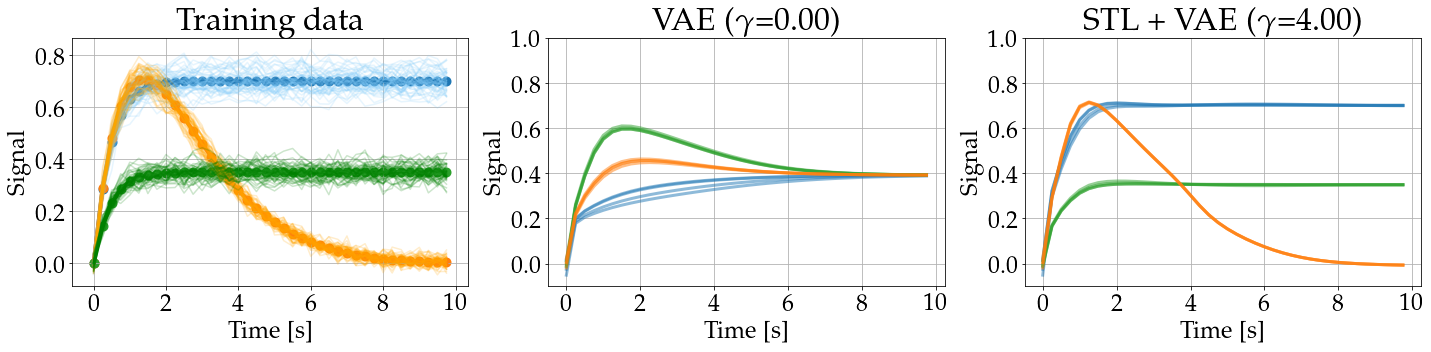

In [88]:
fontsize = 24
color_list = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = color_list[:3]

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(t, y1, linewidth=4)
plt.plot(t, y2, linewidth=4)
plt.plot(t, y3, linewidth=4)

plt.scatter(t, y1, linewidth=4)
plt.scatter(t, y2, linewidth=4)
plt.scatter(t, y3, linewidth=4)

plt.plot(t, noisy_y1.T, alpha=alpha, c="lightskyblue")
plt.plot(t, noisy_y2.T, alpha=alpha, c="orange")
plt.plot(t, noisy_y3.T, alpha=alpha, c="green")

plt.xlabel("Time [s]", fontsize=fontsize)
plt.ylabel("Signal", fontsize=fontsize)
plt.title("Training data", fontsize=fontsize+8)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid()


plt.subplot(1,3,3)
for i in range(3):
    plt.plot(np.arange(0, tmax, 0.25), stlvae_output.squeeze().detach().cpu()[4*i:4*i+4,:].T, linewidth=3, c=color_list[i], alpha=0.5)
plt.xlabel("Time [s]", fontsize=fontsize)
plt.ylabel("Signal", fontsize=fontsize)
plt.title("STL + VAE ($\gamma $=%.2f)"%λ, fontsize=fontsize+8)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim([-0.1, 1.0])
plt.grid()


plt.subplot(1,3,2)
for i in range(3):
    plt.plot(np.arange(0, tmax, 0.25), vae_output.squeeze().detach().cpu()[4*i:4*i+4,:].T, linewidth=3, c=color_list[i], alpha=0.5)
plt.xlabel("Time [s]", fontsize=fontsize)
plt.ylabel("Signal", fontsize=fontsize)
plt.title("VAE ($\gamma $=0.00)", fontsize=fontsize+8)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim([-0.1, 1.0])
plt.grid()
plt.tight_layout()
# plt.savefig("figs/latentspace/latent_space_results.png")

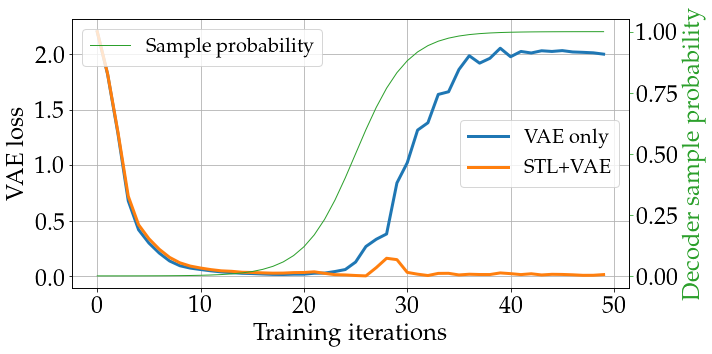

In [98]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.tick_params(axis='x', labelsize=fontsize)
ax1.tick_params(axis='y', labelsize=fontsize)

ax1.set_xlabel('Training iterations', fontsize=fontsize)
ax1.set_ylabel('VAE loss', fontsize=fontsize)
ax1.plot(vae_losses, label="VAE only", linewidth=3)
ax1.plot(losses[1], label="STL+VAE", linewidth=3)
# ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
ax1.legend(fontsize=fontsize-4)


eps = np.arange(epochs)
probs = 1/(1 + np.exp(-20./epochs*(eps - epochs/2)))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Decoder sample probability', fontsize=fontsize, color=color)  # we already handled the x-label with ax1
ax2.plot(probs, color=color,  linewidth=1, label="Sample probability")
ax2.tick_params(axis='y',labelsize=fontsize, color=color)
ax2.legend(fontsize=fontsize-4)
plt.tight_layout()
